In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.io
import scipy.stats as stats
import scipy.linalg as ln
import matplotlib.pyplot as plt
import nmarkov as nm

## Load matrices from JSPetriNet

### Generated from generalized stochastic Petri nets

- SPN fie: iaas_cloud.spn

```plain
/*
  Example: IaaS Cloud (monolithic)
  R. Ghosh, F. Longo, F. Frattini, S. Russo and K.S. Trivedi,
  Scalable analytics for IaaS cloud availability,
  IEEE Transactions on Cloud Computing, 2:1, 57-70, 2014.
*/

/*
  Initial tokes are given by an option imark
  Example:
   - The numbers of servers in hot, warm and cold pools are 3

  In the above case, the imark option should be
     -imark "Ph:3,Pw:3,Pc:3"
*/

n = 3

place Ph (init = n)
place Pfh
place Pchm
place Pwhm
place Pbc_d
place Pbw
place Phcm
place Phwm
place Pwr
place Pw (init = n)
place Pfw
place Pcwm
place Pbc_dd
place Pwcm
place Pcr
place Pc (init = n)
place Pfc

exp Thr (guard = g2)
exp Thf (rate = r1, guard = g2)
exp Tbchf (guard = g1, rate = r1)
exp Tbwhf (rate = r1)
exp Tchm
exp Twhm
exp Twr (guard = g4)
exp Thcm
exp Thwm
exp Twf (guard = g3, rate = r2)
exp Tbcwf (rate = r2)
exp Tcf (rate = r3)
exp Tcwm
exp Tcr (guard = g5)
exp Twcm

imm tcr1
imm twr1
imm twr2
imm tcr2
imm tcr3

iarc Ph to Thf
iarc Ph to Tbchf
iarc Ph to Tbwhf
iarc Pfh to Thr
iarc Pchm to Tchm
iarc Pwhm to Twhm
iarc Pbc_d to tcr1
iarc Pbw to twr1
iarc Phcm to Thcm
iarc Phwm to Thwm
iarc Pwr to twr1
iarc Pwr to twr2
iarc Pw to Twf
iarc Pw to Tbwhf
iarc Pw to Tbcwf
iarc Pfw to twr2
iarc Pcwm to Tcwm
iarc Pbc_dd to tcr2
iarc Pwcm to Twcm
iarc Pcr to tcr1
iarc Pcr to tcr2
iarc Pcr to tcr3
iarc Pfc to tcr3
iarc Pc to Tcf
iarc Pc to Tbcwf
iarc Pc to Tbchf

oarc Thr to Ph
oarc Thf to Pfh
oarc Tbchf to Pchm
oarc Tbwhf to Pwhm
oarc Tchm to Ph
oarc Tchm to Pbc_d
oarc Twhm to Ph
oarc Twhm to Pbw
oarc tcr1 to Phcm
oarc twr1 to Phwm
oarc twr2 to Pw
oarc Twr to Pwr
oarc Thcm to Pc
oarc Thwm to Pw
oarc Twf to Pfw
oarc Tbcwf to Pcwm
oarc Tcwm to Pbc_dd
oarc Tcwm to Pw
oarc tcr2 to Pwcm
oarc Tcr to Pcr
oarc tcr3 to Pc
oarc Tcf to Pfc
oarc Twcm to Pc

g1 = #Pw == 0
g2 = (#Pw == 0) && (#Pc == 0)
g3 = #Pc == 0
g4 = #Pfw + #Pbw > 0
g5 = #Pfc + #Pbc_d + #Pbc_dd > 0

r1 = #Ph * lambda_h
r2 = #Pw * lambda_w
r3 = #Pc * lambda_c

lambda_h = 1/(500*60) // MTTF 500hrs
lambda_w = 1/(1750*60) // MTTF 1750hrs
lambda_c = 1/(2500*60) // MTTF 2500hrs

nr = 1
mu = 1/(3*60) // MTTR 3hrs

gam.ch = 1/30 // MTTM 30min
gam.wh = 1/30 // MTTM 30min
gam.hc = 1/30 // MTTM 30min
gam.hw = 1/30 // MTTM 30min
gam.cw = 1/30 // MTTM 30min
gam.wc = 1/30 // MTTM 30min

Thr.rate = ifelse(#Pfh <= nr, #Pfh * mu, nr * mu)
Twr.rate = ifelse(#Pfw + #Pbw <= nr, mu*(#Pfw + #Pbw), nr * mu)
Tcr.rate = ifelse(#Pfc + #Pbc_d + #Pbc_dd <= nr, (#Pfc + #Pbc_d + #Pbc_dd) * mu, nr * mu)

Tchm.rate = #Pchm * gam.ch
Twhm.rate = #Pwhm * gam.wh
Thcm.rate = #Phcm * gam.hc
Thwm.rate = #Phwm * gam.hw
Tcwm.rate = #Pcwm * gam.cw
Twcm.rate = #Pwcm * gam.wc

rwd1 = #Ph
rwd2 = #Pw
rwd3 = #Pc

avail1 = ifelse(#Ph >= 1, 1.0, 0.0)
avail2 = ifelse(#Ph >= 2, 1.0, 0.0)
avail3 = ifelse(#Ph >= 3, 1.0, 0.0)

rwd5 = ifelse(#Pw >= 1, 1.0, 0.0)
rwd6 = ifelse(#Pc >= 1, 1.0, 0.0)
```

- Command to generate matrix

```plain
$ cat example/iaas_cloud.spn | java -jar JSPetriNet-0.10.3-dev.jar mark -tangible -bin -o test -reward rwd1,rwd2,rwd3
Initial marking: Ph:3,Pw:3,Pc:3
Create marking...done
computation time    : 0.197712606 (sec)
# of total states   : 14110
# of IMM states     : 3838
# of EXP/GEN states : 10272
(EXP)
  # of IMM states     : 3838
  # of EXP/GEN states : 10272

# I0G0 I0 to G0
# size 3838 10272 7795
# G0I0E G0 to I0
# size 10272 3838 3838
# G0G0E G0 to G0
# size 10272 10272 47358
# I0init (EXP)
# size 3838 1
# G0init (EXP)
# size 10272 1
# I0sum (EXP)
# size 3838 1
# G0Esum (EXP)
# size 10272 1
# G0rwd (EXP)
# size 10272 3
```

In [2]:
mat = scipy.io.loadmat('test.mat')

## Make CTMC infinitesimal generator

- Vanishing immediate states:
$$
Q = Q_{00} + Q_{01} P_{10}
$$
$$
Q = Q - \text{diag}_{0}
$$

In [3]:
Q=nm.smatrix(mat['G0G0E']) + nm.smatrix(mat['G0I0E'] @ sp.diags(1/mat['I0sum'].flatten()) @ mat['I0G0'])
Q=Q - nm.diags(mat['G0Esum'].flatten())

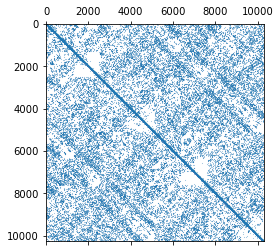

In [4]:
plt.spy(Q.tocoo(), markersize=.1)

## Compute rewards (transient solution)
- $x_0$: initial vector
- $r$: reward matrix
- $t$: a sequence of time points

- Result
    - `irwd`: instantaneous reward, irwd[:,0] is the rewards for the first reward r[:,0]
    - `crwd`: cumulative reward

In [5]:
x0=mat['G0init'].flatten() # column vector should be changed to 1D-array
r=mat['G0rwd']

In [6]:
res=nm.trwd(Q=Q, t=np.linspace(0, 1000, num=1000), x0=x0, rwd=r)

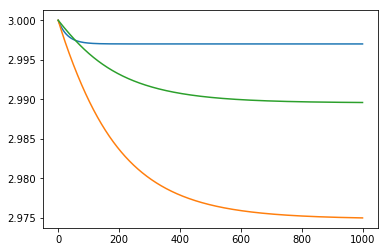

In [7]:
plt.plot(res['t'], res['irwd'][:,0])
plt.plot(res['t'], res['irwd'][:,1])
plt.plot(res['t'], res['irwd'][:,2])
plt.show()

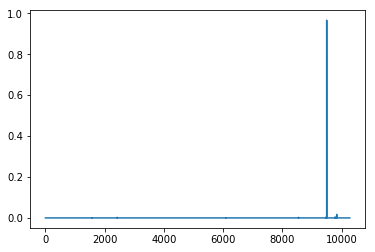

In [10]:
plt.plot(res['prob'])

## Compute rewards (stationary solution)

Solve
$$
\pi Q = 0, \quad \pi 1 = 1
$$
Rewards
$$
\pi r
$$

In [11]:
p=nm.sprob(Q)
p @ r

array([1.42258221, 2.98765439, 2.98951991])

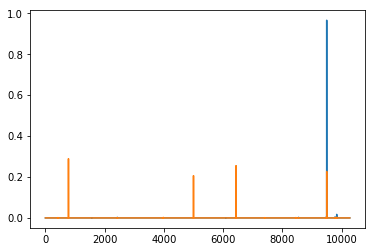

In [12]:
plt.plot(res['prob'])
plt.plot(p)
plt.show()